<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Random_forest_Modular_Correct(Daily_New).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [943]:
! git clone https://github.com/anirbanghoshsbi/pandas-technical-indicators.git

Cloning into 'pandas-technical-indicators'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 202 (delta 105), reused 0 (delta 0), pack-reused 27
Receiving objects: 100% (202/202), 58.64 KiB | 14.66 MiB/s, done.
Resolving deltas: 100% (117/117), done.


In [944]:
!pwd

/content/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators


In [945]:
%cd pandas-technical-indicators

/content/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators/pandas-technical-indicators


In [946]:
!pip install yfinance

In [947]:
# Import libraries
import os
import sys
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [948]:
import technical_indicators as ta
import random_forest as rf
import confusionMatrix as cm
import easy_line_ploting as linplt

In [949]:
tickr ='goldbees.ns'   #'^NSEI' #^NSEBANK  #^cnxit #^GSPC #^YHOH714

In [950]:
df_old = pd.DataFrame()

In [951]:
df_old = yf.download(tickr,'2008-01-01','2017-05-01')

[*********************100%***********************]  1 of 1 completed


In [952]:
df_old.shape

(2040, 6)

# INPUT

In [953]:
# INPUT .........

#  ********************************* #

t=2
days_out=14


#  ********************************* #

In [954]:
def get_supertrend(high, low, close, lookback, multiplier):
    
    # ATR
    
    tr1 = pd.DataFrame(high - low)
    tr2 = pd.DataFrame(abs(high - close.shift(1)))
    tr3 = pd.DataFrame(abs(low - close.shift(1)))
    frames = [tr1, tr2, tr3]
    tr = pd.concat(frames, axis = 1, join = 'inner').max(axis = 1)
    atr = tr.ewm(lookback).mean()
    
    # H/L AVG AND BASIC UPPER & LOWER BAND
    
    hl_avg = (high + low) / 2
    upper_band = (hl_avg + multiplier * atr).dropna()
    lower_band = (hl_avg - multiplier * atr).dropna()
    
    # FINAL UPPER BAND
    final_bands = pd.DataFrame(columns = ['upper', 'lower'])
    final_bands.iloc[:,0] = [x for x in upper_band - upper_band]
    final_bands.iloc[:,1] = final_bands.iloc[:,0]
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i,0] = 0
        else:
            if (upper_band[i] < final_bands.iloc[i-1,0]) | (close[i-1] > final_bands.iloc[i-1,0]):
                final_bands.iloc[i,0] = upper_band[i]
            else:
                final_bands.iloc[i,0] = final_bands.iloc[i-1,0]
    
    # FINAL LOWER BAND
    
    for i in range(len(final_bands)):
        if i == 0:
            final_bands.iloc[i, 1] = 0
        else:
            if (lower_band[i] > final_bands.iloc[i-1,1]) | (close[i-1] < final_bands.iloc[i-1,1]):
                final_bands.iloc[i,1] = lower_band[i]
            else:
                final_bands.iloc[i,1] = final_bands.iloc[i-1,1]
    
    # SUPERTREND
    
    supertrend = pd.DataFrame(columns = [f'supertrend_{lookback}'])
    supertrend.iloc[:,0] = [x for x in final_bands['upper'] - final_bands['upper']]
    
    for i in range(len(supertrend)):
        if i == 0:
            supertrend.iloc[i, 0] = 0
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] < final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 0] and close[i] > final_bands.iloc[i, 0]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] > final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 1]
        elif supertrend.iloc[i-1, 0] == final_bands.iloc[i-1, 1] and close[i] < final_bands.iloc[i, 1]:
            supertrend.iloc[i, 0] = final_bands.iloc[i, 0]
    
    supertrend = supertrend.set_index(upper_band.index)
    supertrend = supertrend.dropna()[1:]
    
    # ST UPTREND/DOWNTREND
    
    upt = []
    dt = []
    close = close.iloc[len(close) - len(supertrend):]

    for i in range(len(supertrend)):
        if close[i] > supertrend.iloc[i, 0]:
            upt.append(supertrend.iloc[i, 0])
            dt.append(np.nan)
        elif close[i] < supertrend.iloc[i, 0]:
            upt.append(np.nan)
            dt.append(supertrend.iloc[i, 0])
        else:
            upt.append(np.nan)
            dt.append(np.nan)
            
    st, upt, dt = pd.Series(supertrend.iloc[:, 0]), pd.Series(upt), pd.Series(dt)
    upt.index, dt.index = supertrend.index, supertrend.index
    
    return st, upt, dt

In [955]:
def get_indicators(data ,days_out,t=1):
    data = ta.relative_strength_index(data,days_out)
    #data=ta.exponential_moving_average(data,10*t)
    data=ta.exponential_moving_average(data,50*t)
    data=ta.momentum(data,7*t)
    data=ta.rate_of_change(data,7*t)
    data=ta.exponential_moving_average(data,7*t)
    
    #data=ta.exponential_moving_average(data , 13*t)
    #data=ta.exponential_moving_average(data ,26*t)
    data=ta.force_index(data ,days_out)
    data = ta.on_balance_volume(data , days_out)
    data = ta.standard_deviation(data , days_out)
    data = ta.stochastic_oscillator_d(data ,days_out)
    data = ta.stochastic_oscillator_k(data)
    data = ta.macd(data , 9 , 12)
    data = ta.ppsr(data)
    data = ta.trix(data,days_out)
    data = ta.vortex_indicator(data , days_out)
    data = ta.find_window_high_low(data,days_out)
    #data = ta.keltner_channel(data , 13)
    #data['change_in_price'] = data['Close'].diff()
    
    return data


# Check This For Weekly or Daily 

In [956]:
############################ Comment or Uncomment Based on Daily or Weekly ##########

#df_old=df_old.resample('W').last()

In [957]:
train=int(len(df_old)*.75)
df_train= df_old[:train]
df_test= df_old[train+50:]

In [958]:
df_train.shape , df_test.shape

((1530, 6), (460, 6))

In [959]:
df_train = get_indicators(df_train,days_out,1)
df_test= get_indicators(df_test,days_out,1)

In [960]:
df_old.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-27,26.3295,26.399,26.2605,26.333,26.333,2169100
2017-04-28,26.3300,26.549,26.3300,26.410,26.410,4292500


In [961]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_train['Signal_Flag'] = df_train['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_train = df_train.dropna()

In [962]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df_test['Signal_Flag'] = df_test['Close'].transform(lambda x : np.sign(x.diff(days_out)))

df_test = df_test.dropna()

In [963]:
X_train = df_train.drop(['Signal_Flag'],axis=1)
y_train = df_train['Signal_Flag']
X_test = df_test.drop(['Signal_Flag'],axis=1)
y_test = df_test['Signal_Flag']

In [964]:
############## JUST REMOVE # TO COMPUTE THE BEST PARAMETERS #######################

#rf.best_param_rf(X_train , y_train , 100)

In [965]:
'''
>>> 100 iterations
{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished
{'Best Score': 0.9169554134840112,
 'Best parameters': {'bootstrap': True,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 60,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 7,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 200,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  
>>> for n_iter=300
{'Best Score': 0.9654412531082027,
 'Best parameters': {'bootstrap': False,
  'ccp_alpha': 0.0,
  'class_weight': None,
  'criterion': 'gini',
  'max_depth': 10,
  'max_features': None,
  'max_leaf_nodes': None,
  'max_samples': None,
  'min_impurity_decrease': 0.0,
  'min_impurity_split': None,
  'min_samples_leaf': 16,
  'min_samples_split': 5,
  'min_weight_fraction_leaf': 0.0,
  'n_estimators': 1800,
  'n_jobs': None,
  'oob_score': False,
  'random_state': None,
  'verbose': 0,
  'warm_start': False}}
  '''

"\n100 iterations\n{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}\nFitting 3 folds for each of 100 candidates, totalling 300 fits\n[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.\n[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min\n[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.3min\n[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 37.9min finished\n{'Best Score': 0.9169554134840112,\n 'Best parameters': {'bootstrap': True,\n  'ccp_alpha': 0.0,\n  'class_weight': None,\n  'criterion': 'gini',\n  'max_depth': 60,\n  'max_features': None,\n  'max_leaf_nodes': None,\n  'max_samples': None,\n  'min_impurity_decrease': 0.0,\n  'min_impurity_split': None,\n  'min_samples_leaf': 7,\n  'min_sa

In [966]:
# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=80,min_samples_leaf=2,max_features='auto', min_samples_split=2, criterion = "gini", bootstrap=True,random_state = 42)
# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)


In [967]:
# Print the Accuracy of our Model.
print('Correct Prediction RForest (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction RForest (%):  93.18734793187348


Accuracy: 93.18734793187348
Percision: 93.72197309417041
Recall: 93.72197309417041
Specificity: 92.5531914893617


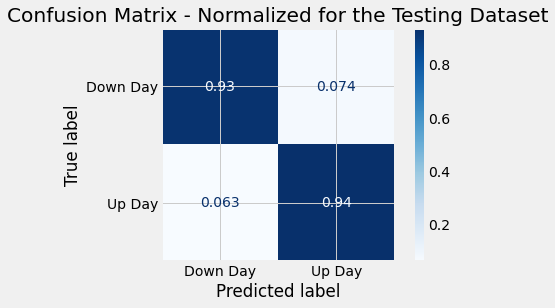

In [968]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True )

#cm.confus_matrix(actual_results , predictions,model ,<test data ( or new_data for prediction except target VAR)>, <actaul Target VAR> , <plot=True>)

In [969]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp*100
feats=X_train.columns

# Logistic Regression

In [970]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
#from sklearn.cross_validation import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [971]:
LogReg = LogisticRegression()
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
LogReg.fit(X_train, y_train)
y_predL = LogReg.predict(X_test)

In [972]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, LogReg.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  93.91727493917274


Accuracy: 93.91727493917274
Percision: 94.5945945945946
Recall: 94.17040358744396
Specificity: 93.61702127659575


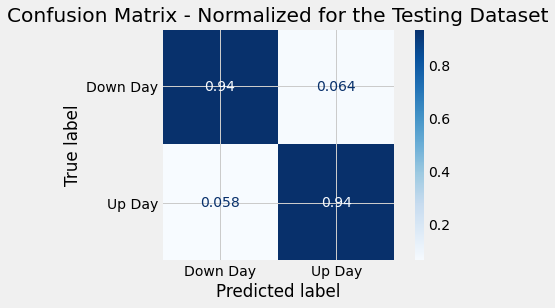

In [973]:
cm.confus_matrix(y_test,y_predL,LogReg,X_test,y_test,plot=True )

# Support Vector Classifier

In [974]:
from sklearn.svm import SVC
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
svc_classifier = SVC(kernel = 'linear', random_state = 0)
svc_classifier.fit(X_train, y_train)
y_predS = svc_classifier.predict(X_test)

In [975]:
# Print the Accuracy of our Model.
print('Correct Prediction Logistic Regression (%): ', accuracy_score(y_test, svc_classifier.predict(X_test), normalize = True) * 100.0)

Correct Prediction Logistic Regression (%):  93.43065693430657


Accuracy: 93.43065693430657
Percision: 94.54545454545455
Recall: 93.27354260089686
Specificity: 93.61702127659575


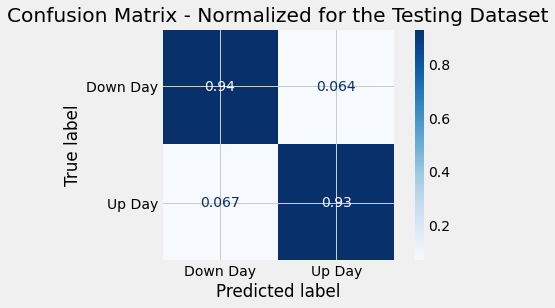

In [976]:
cm.confus_matrix(y_test,y_predS,svc_classifier,X_test,y_test,plot=True )

# XGBoost Classifier

In [977]:
import xgboost as xgb

In [978]:
'''
param_test1 = {
 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],
 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],
 'n_estimators': [10,50,100,200,300]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)
 
gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_
'''

"\nparam_test1 = {\n 'max_depth':range(3,6,2),'learning_rate':[0.001,0.01,0.1,0.05],\n 'min_child_weight':range(1,4,2),'reg_alpha':[0, 0.001, 0.005, 0.01],'subsample':[i/100.0 for i in range(75,90,5)],\n 'colsample_bytree':[i/100.0 for i in range(75,85,5)],'gamma':[i/10.0 for i in range(0,2)],\n 'n_estimators': [10,50,100,200,300]\n}\ngsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,reg_alpha=1e-5,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,verbose=10,cv=5)\n \ngsearch1.fit(X_train,y_train)\ngsearch1.best_params_, gsearch1.best_score_\n"

In [979]:
xgb_classifier = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=200,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_classifier.fit(X_train, y_train)
y_predX = xgb_classifier.predict(X_test)
print("Accuracy for XGBoost Model: %.2f" % (accuracy_score(y_test, y_predX) * 100))

Accuracy for XGBoost Model: 93.67


Accuracy: 93.67396593673966
Percision: 94.97716894977168
Recall: 93.27354260089686
Specificity: 94.14893617021278


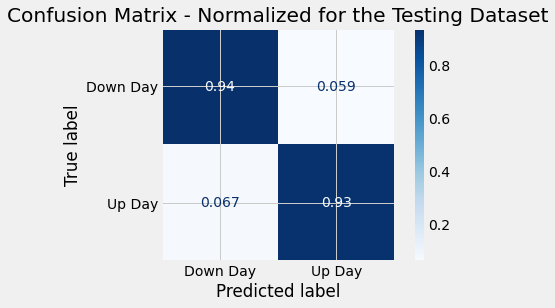

In [980]:
cm.confus_matrix(y_test,y_predX,xgb_classifier,X_test,y_test,plot=True )

In [981]:
feature_imp_XGB = pd.Series(xgb_classifier.feature_importances_, index=feats).sort_values(ascending=False)
feature_imp_XGB*100

Vortex_14                   33.917000
MACD_9_12                   11.153203
PP                           6.207302
OBV_14                       2.586601
SO%k                         2.582134
High                         2.464339
MACDdiff_9_12                2.433518
Open                         2.190370
Close                        2.154849
Low                          2.151186
S3                           2.050474
R3                           1.993287
STD_14                       1.982941
EMA_7                        1.957238
RSI_14                       1.927002
S1                           1.889263
R2                           1.840628
Trix_14                      1.837371
Win_Low                      1.821492
SO%d_14                      1.819944
EMA_50                       1.758560
Force_14                     1.663712
Volume                       1.662279
Momentum_7                   1.549620
MACDsign_9_12                1.463702
ROC_7                        1.415182
R1          

In [982]:
features = {'Random Forest' : feature_imp,'XGBoost': feature_imp_XGB}
feats=pd.DataFrame(features)

In [983]:
feats.sort_values(by=['XGBoost'],ascending=False)

,Random Forest,XGBoost
Vortex_14,0.289648,0.339170
MACD_9_12,0.178203,0.111532
PP,0.004955,0.062073
OBV_14,0.094832,0.025866
SO%k,0.010378,0.025821
High,0.005459,0.024643
MACDdiff_9_12,0.024287,0.024335
Open,0.003587,0.021904
Close,0.006202,0.021548
Low,0.004566,0.021512


# Make Actual Prediction

In [984]:
df = pd.DataFrame()

In [985]:
df = yf.download(tickr,'2019-01-01')

[*********************100%***********************]  1 of 1 completed


In [986]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-14,41.119999,41.119999,40.340000,40.730000,40.730000,2019311
2021-09-15,41.430000,41.430000,40.580002,40.959999,40.959999,4593529
2021-09-16,41.220001,41.220001,40.459999,40.520000,40.520000,7747661


# Check This For Weekly or Daily

In [987]:
####################### Comment or Uncomment Based on Weekly or Daily ##################
#df=df.resample('W').last()

In [988]:
df = get_indicators(df,days_out,1)
#df= impulse(df)

In [989]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,RSI_14,EMA_50,Momentum_7,ROC_7,EMA_7,Force_14,OBV_14,STD_14,SO%d_14,SO%k,MACD_9_12,MACDsign_9_12,MACDdiff_9_12,PP,R1,S1,R2,S2,R3,S3,Trix_14,Vortex_14,Win_High,Win_Low,Signals_from_Window_HiLo
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-09-15,41.430000,41.430000,40.580002,40.959999,40.959999,4593529,0.816522,41.080733,0.040001,-0.006066,40.868841,-2.361662e+05,137371.071429,0.133860,0.356591,0.447056,-0.012183,-0.010717,-0.001466,40.990000,41.399999,40.550001,41.839999,40.140002,42.249997,39.700002,-0.000266,-0.030789,44.400002,40.34,0.0
2021-09-16,41.220001,41.220001,40.459999,40.520000,40.520000,7747661,0.775100,41.058743,-0.689999,-0.013152,40.781631,-1.681844e+06,-291672.571429,0.166072,0.319572,0.078949,-0.026825,-0.013939,-0.012887,40.733334,41.006668,40.246666,41.493336,39.973331,41.766670,39.486664,-0.000277,-0.295492,44.400002,40.34,0.0


In [990]:
df_old.head(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,0.0,13.43,13.30,13.3700,13.3700,1043400
2009-01-05,0.0,13.32,13.15,13.1555,13.1555,1294700


In [991]:
# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
df['Signal_Flag'] = df['Close'].transform(lambda x : np.sign(x.diff(days_out)))

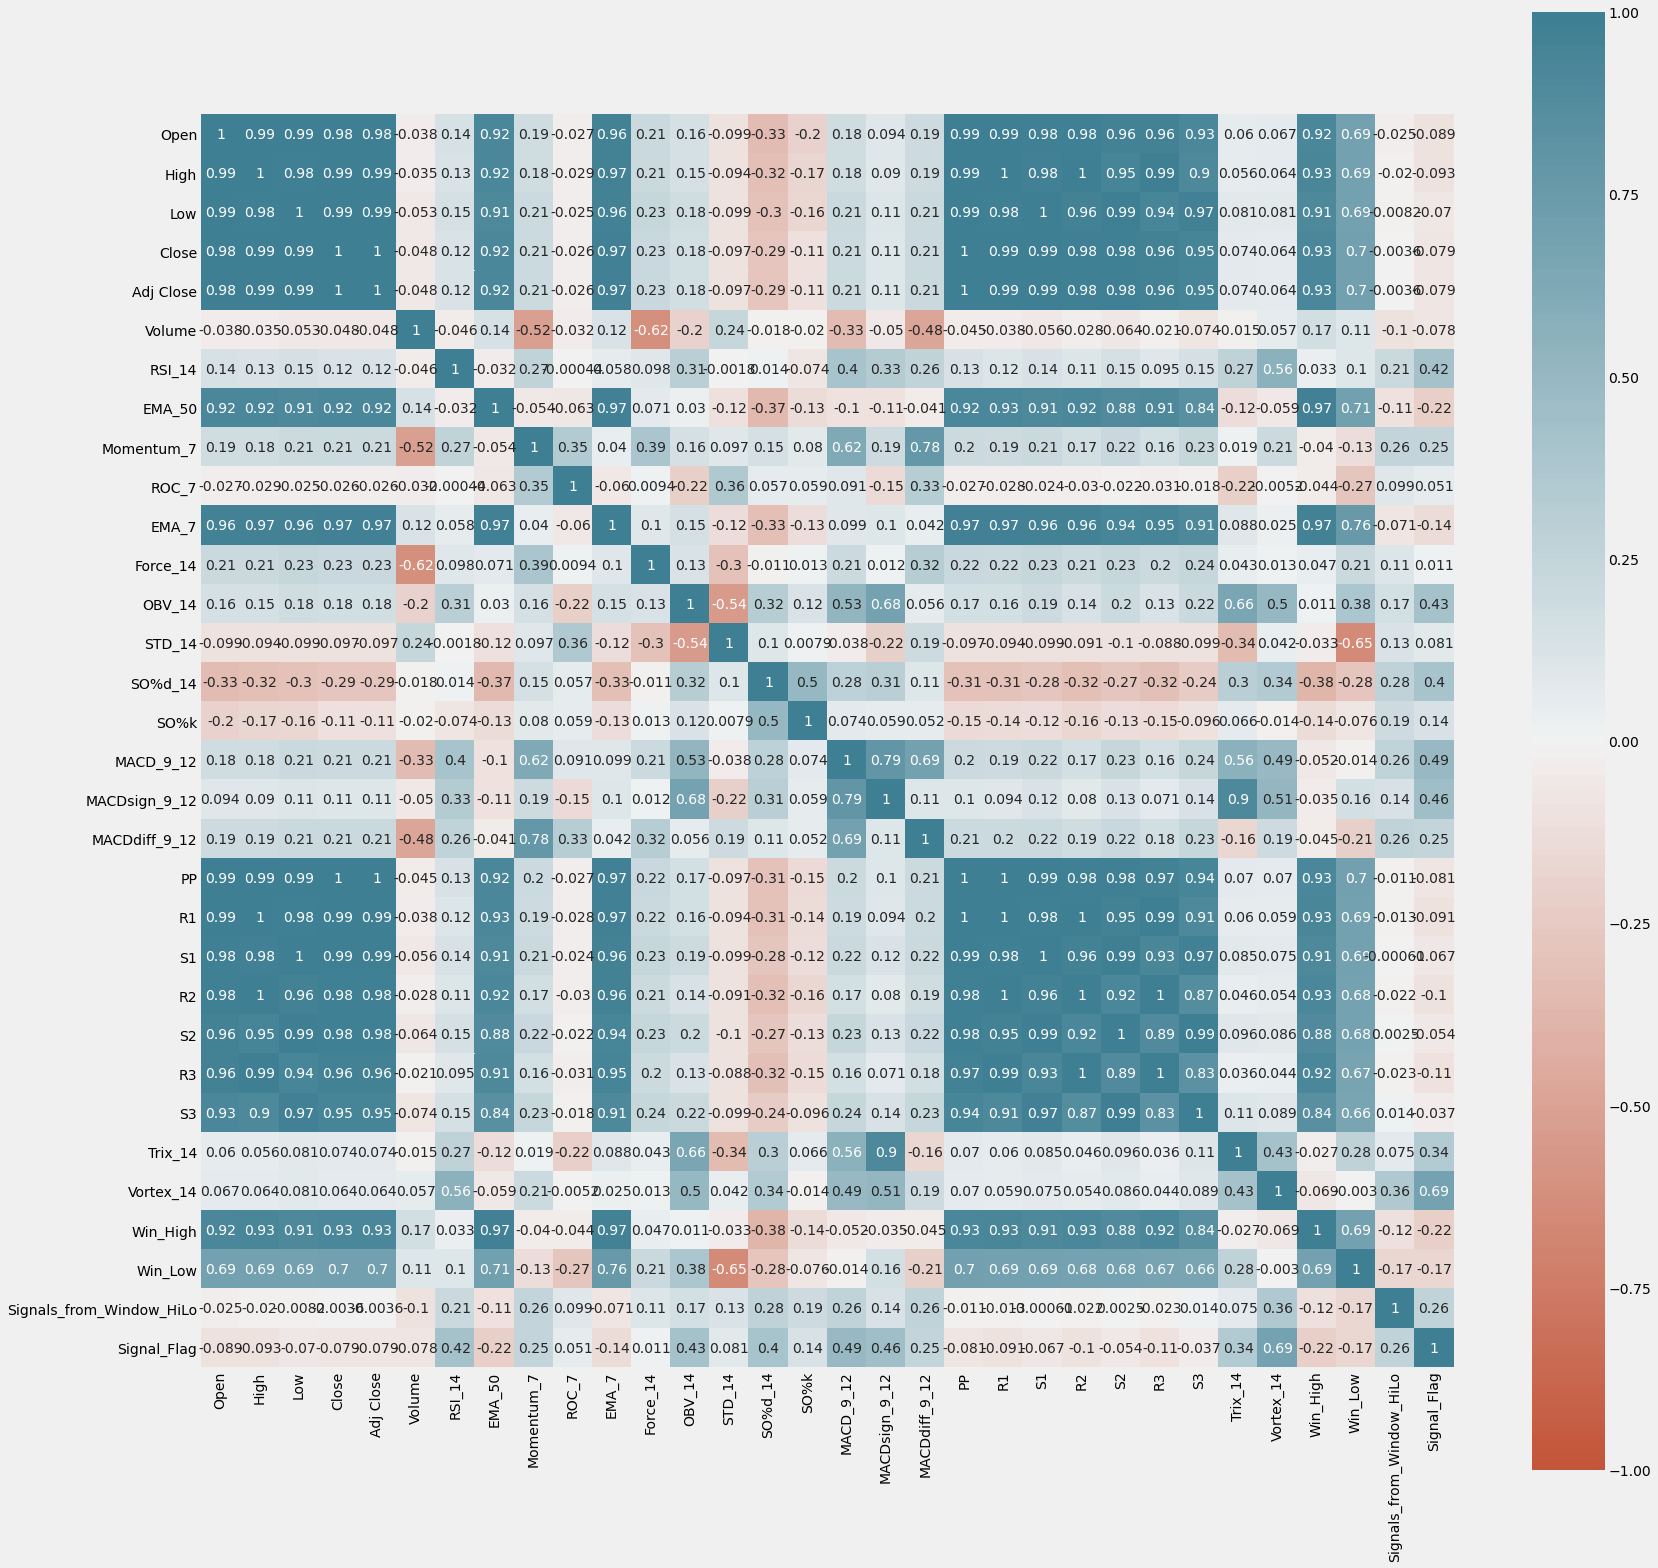

In [992]:
ta.correlation_map(df,25)

In [993]:
df.shape

(667, 32)

In [994]:
df=df.dropna()

In [995]:
df.shape

(618, 32)

In [996]:
new_data = df.drop(['Signal_Flag'],axis=1)
actuals= df['Signal_Flag']


# Make Predictions Using Random Forest

In [997]:
model='random_forest'

In [998]:
preds=rf.make_preds(new_data ,rand_frst_clf,model,df)

In [999]:
print("days_out : ",days_out)

days_out :  14


In [1000]:
preds.head(2)

,predsrandom_forest
Date,
2019-03-13,-1.0
2019-03-14,-1.0


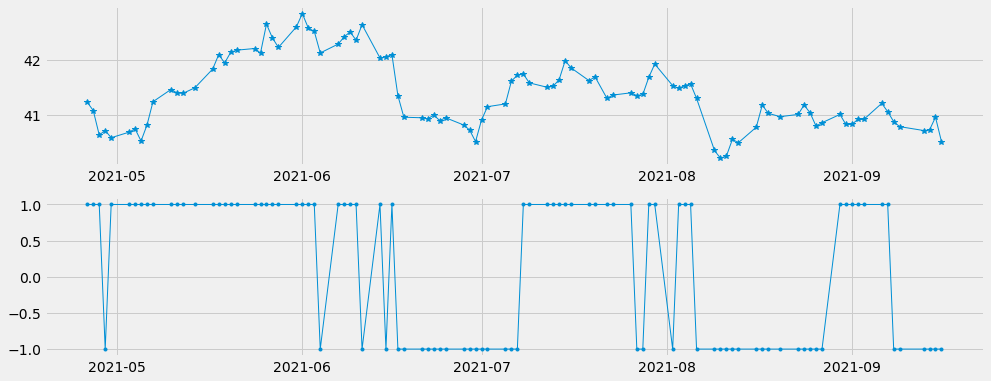

In [1001]:
linplt.lineplot(2,15,6,df,preds['predsrandom_forest'], no_of_datapoints=100) # no_of_datapoints=100

In [1002]:
pred = pd.DataFrame(rf.make_preds(new_data , rand_frst_clf, model,df))

In [1003]:
pred.head(2)

,predsrandom_forest
Date,
2019-03-13,-1.0
2019-03-14,-1.0


In [1004]:
pred = pd.concat([pred ,df.Close],axis=1)
#pred.columns=['Date','preds','Close']
#pred= pred.set_index('Date')

In [1005]:
l= len(pred)

In [1006]:
#fig, ax = plt.subplots(1,1,figsize=(20,7))
#Identifying the buy/sell zone
pred['Buy_ind'] = np.where((pred['predsrandom_forest']==1), 1, 0)
pred['Sell_ind'] = np.where((pred['predsrandom_forest']==-1), 0, 1)

In [1007]:
pred=pred.reset_index()

# Make Prediction Using XGBoost

In [1008]:
model='_XGB'

In [1009]:
predX=rf.make_preds(new_data.values ,xgb_classifier,model,df)

In [1010]:
predX= pd.concat([predX ,df.Close],axis=1)

In [1011]:
predX.head(2)

,preds_XGB,Close
Date,,
2019-03-13,-1.0,28.595501
2019-03-14,-1.0,28.359501


In [1012]:
#Identifying the buy/sell zone
predX['Buy_ind_XGB'] = np.where((predX['preds_XGB']==1), 1, 0)
predX['Sell_ind_XGB'] = np.where((predX['preds_XGB']==-1), 0, 1)

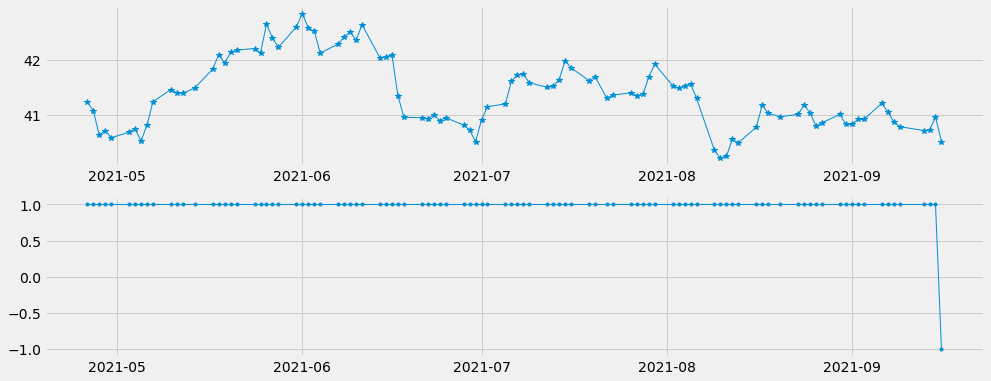

In [1013]:
linplt.lineplot(2,15,6,df,predX['preds_XGB'], no_of_datapoints=100) # no_of_datapoints=100

In [1014]:
predX=predX.reset_index()

# Make Prediction Using Logistics Regression

In [1015]:
model='_Logistic_Regression'

In [1016]:
preds_logreg=pd.DataFrame(rf.make_preds(new_data , LogReg,model, df))

In [1017]:
preds_logreg.head(2)

,preds_Logistic_Regression
Date,
2019-03-13,-1.0
2019-03-14,0.0


In [1018]:
predL = pd.concat([preds_logreg ,df.Close],axis=1)

In [1019]:
predL=predL.reset_index()

In [1020]:
#Identifying the buy/sell zone
predL['Buy_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==1), 1, 0)
predL['Sell_ind_Logreg'] = np.where((predL['preds_Logistic_Regression']==-1), 0, 1)

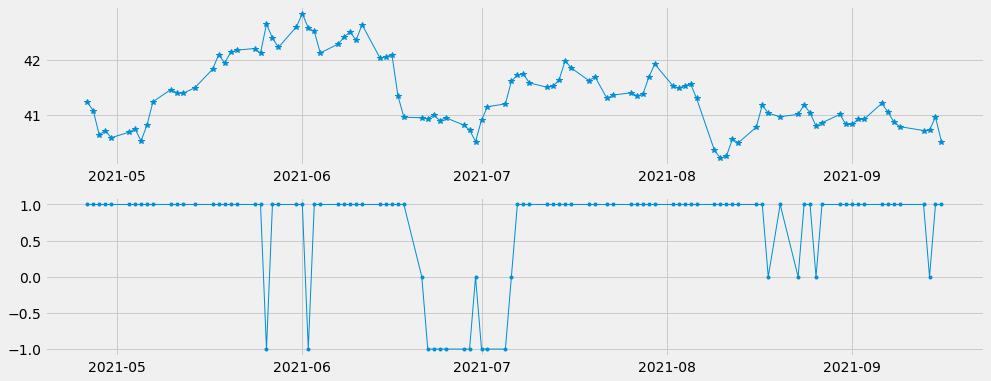

In [1021]:
linplt.lineplot(2,15,6,df,preds_logreg['preds_Logistic_Regression'], no_of_datapoints=100) # no_of_datapoints=100

# Make Predictions using Support Vector Classifier

In [1022]:
model='_SVC'

In [1023]:
preds_svc=pd.DataFrame(rf.make_preds(new_data ,svc_classifier,model, df))

In [1024]:
predS = pd.concat([preds_svc,df.Close],axis=1)

In [1025]:
predS=predS.reset_index()

In [1026]:
#Identifying the buy/sell zone
predS['Buy_ind_SVC'] = np.where((predS['preds_SVC']==1), 1, 0)
predS['Sell_ind_SVC'] = np.where((predS['preds_SVC']==-1), 0, 1)

# PREDICTIONS

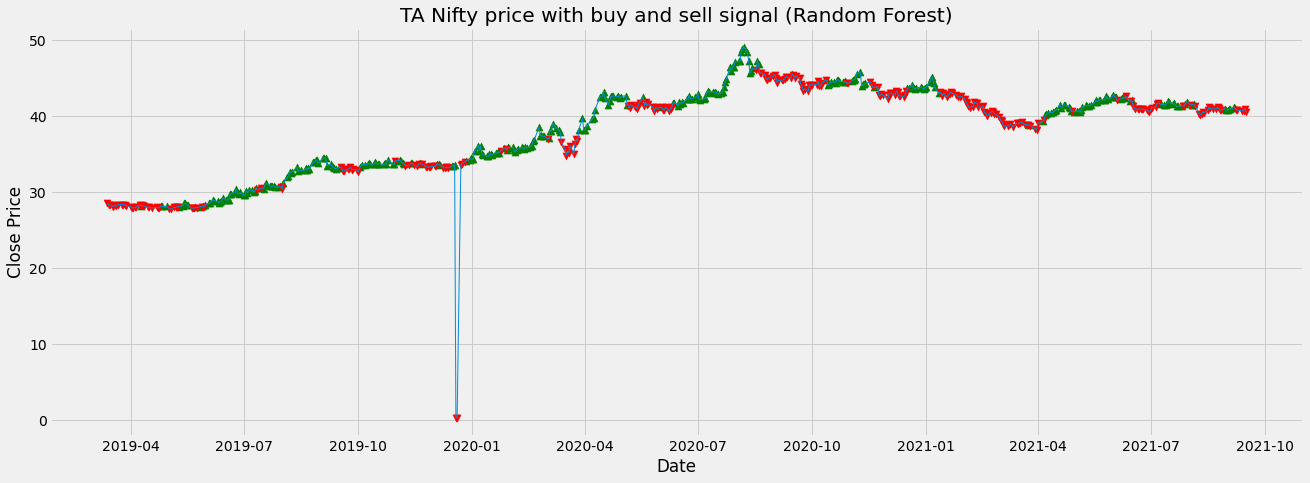

In [1027]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(pred.loc[pred['Buy_ind'] ==1 , 'Date'].values,pred.loc[pred['Buy_ind'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ind'] ==0 , 'Date'].values,pred.loc[pred['Sell_ind'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Random Forest)') 

plt.savefig('a.png')
plt.show();

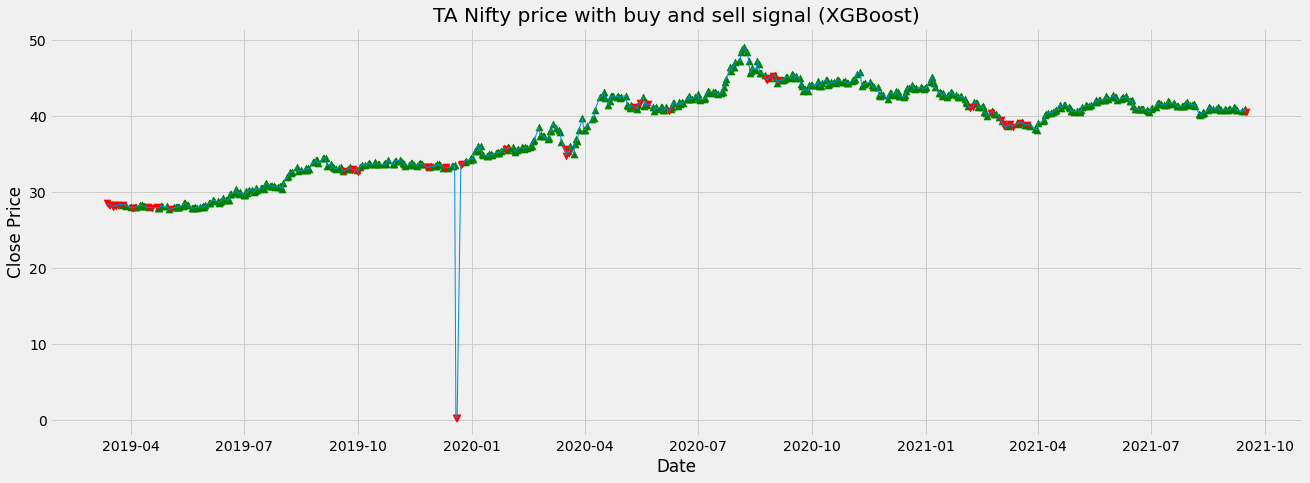

In [1028]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predX.loc[predX['Buy_ind_XGB'] ==1 , 'Date'].values,predX.loc[predX['Buy_ind_XGB'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predX.loc[predX['Sell_ind_XGB'] ==0 , 'Date'].values,predX.loc[predX['Sell_ind_XGB'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (XGBoost)') 

plt.savefig('a.png')
plt.show();

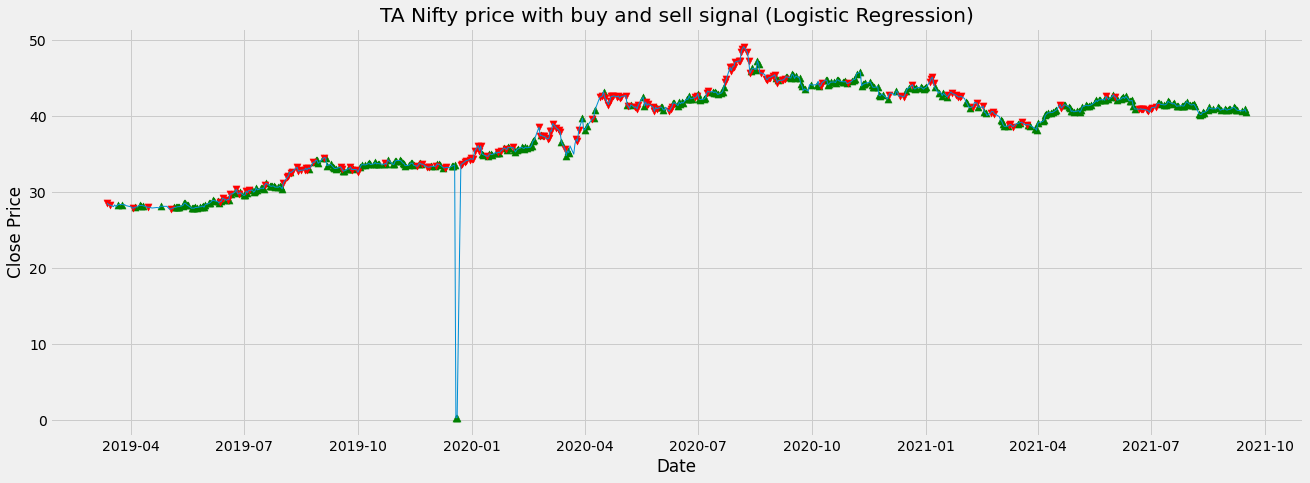

In [1029]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predL.loc[predL['Buy_ind_Logreg'] ==1 , 'Date'].values,predL.loc[predL['Buy_ind_Logreg'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predL.loc[predL['Sell_ind_Logreg'] ==0 , 'Date'].values,predL.loc[predL['Sell_ind_Logreg'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Logistic Regression)') 

plt.savefig('a.png')
plt.show();

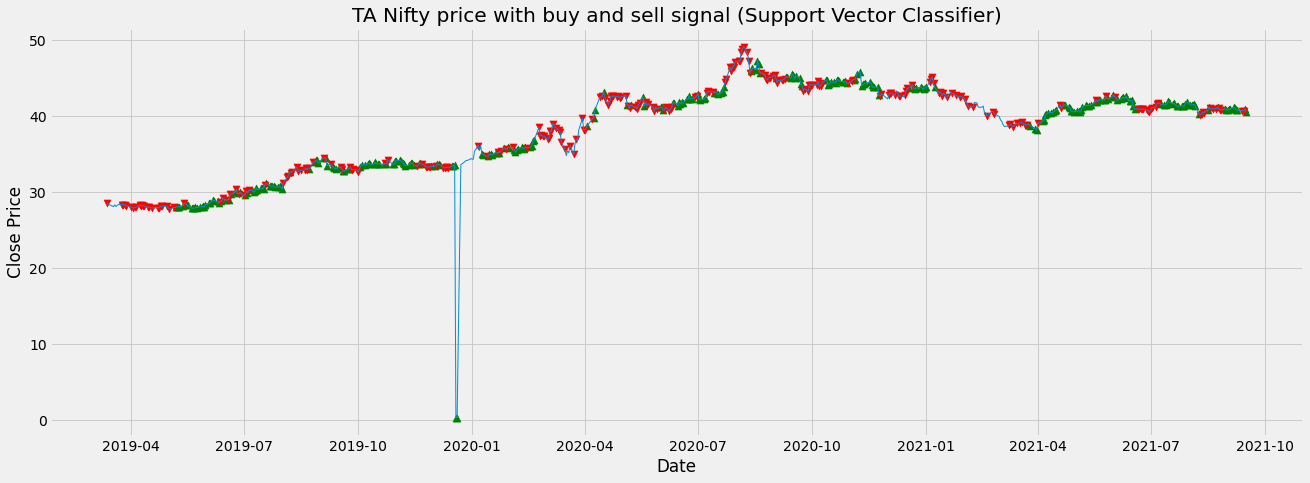

In [1030]:
plt.figure(figsize=(20,7))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=1)
plt.scatter(predS.loc[predS['Buy_ind_SVC'] ==1 , 'Date'].values,predS.loc[predS['Buy_ind_SVC'] ==1, 'Close'].values, label='skitscat', color='green', s=50, marker="^")
plt.scatter(predS.loc[predS['Sell_ind_SVC'] ==0 , 'Date'].values,predS.loc[predS['Sell_ind_SVC'] ==0, 'Close'].values, label='skitscat', color='red', s=50, marker="v")

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price')  
plt.title('TA Nifty price with buy and sell signal (Support Vector Classifier)') 

plt.savefig('a.png')
plt.show();

In [1031]:
pred['ensemble'] = pred['predsrandom_forest']*1.0+predL['preds_Logistic_Regression']*0.25+predS['preds_SVC']*0.25+predX['preds_XGB']*0.5

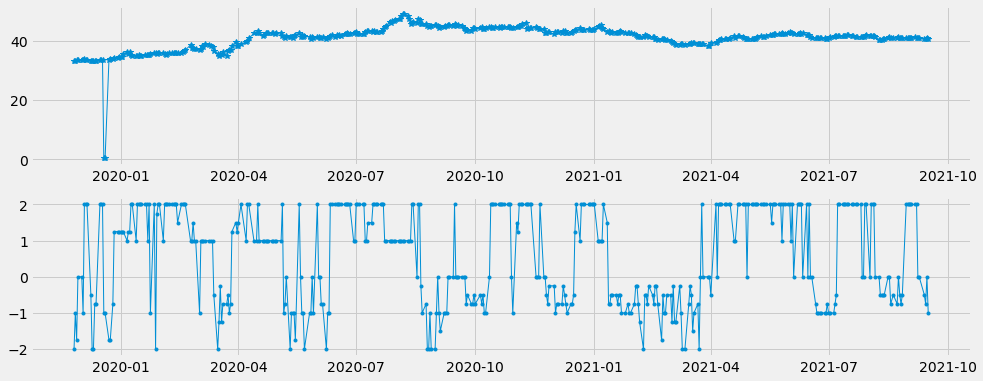

In [1032]:
linplt.lineplot(2,15,6,df,pred['ensemble'], no_of_datapoints=450) # no_of_datapoints=100

In [1033]:
#pred['Signal_from_close']=np.where((pred.Close>pred.Close.shift(1)),1,0)

In [1034]:
#Identifying the buy/sell zone
pred['Buy_ensemble'] = np.where((pred['ensemble']>=0), 1, 0)
pred['Sell_ensemble'] = np.where((pred['ensemble']<0), 0, 1)
#pred['Neutral'] = np.where((pred['ensemble']==-0.5),0,1)
pred['signal4theday']= np.where((pred['ensemble']>=0),1,0)

In [1035]:
pred['signalF']=pred['signal4theday']

In [1036]:
pred.to_csv('rf_ta.csv')

In [1037]:
pred[['signal4theday','signalF','Close']].tail(5)

,signal4theday,signalF,Close
613,1,1,40.790001
614,0,0,40.720001
615,0,0,40.730000
616,1,1,40.959999
617,0,0,40.520000


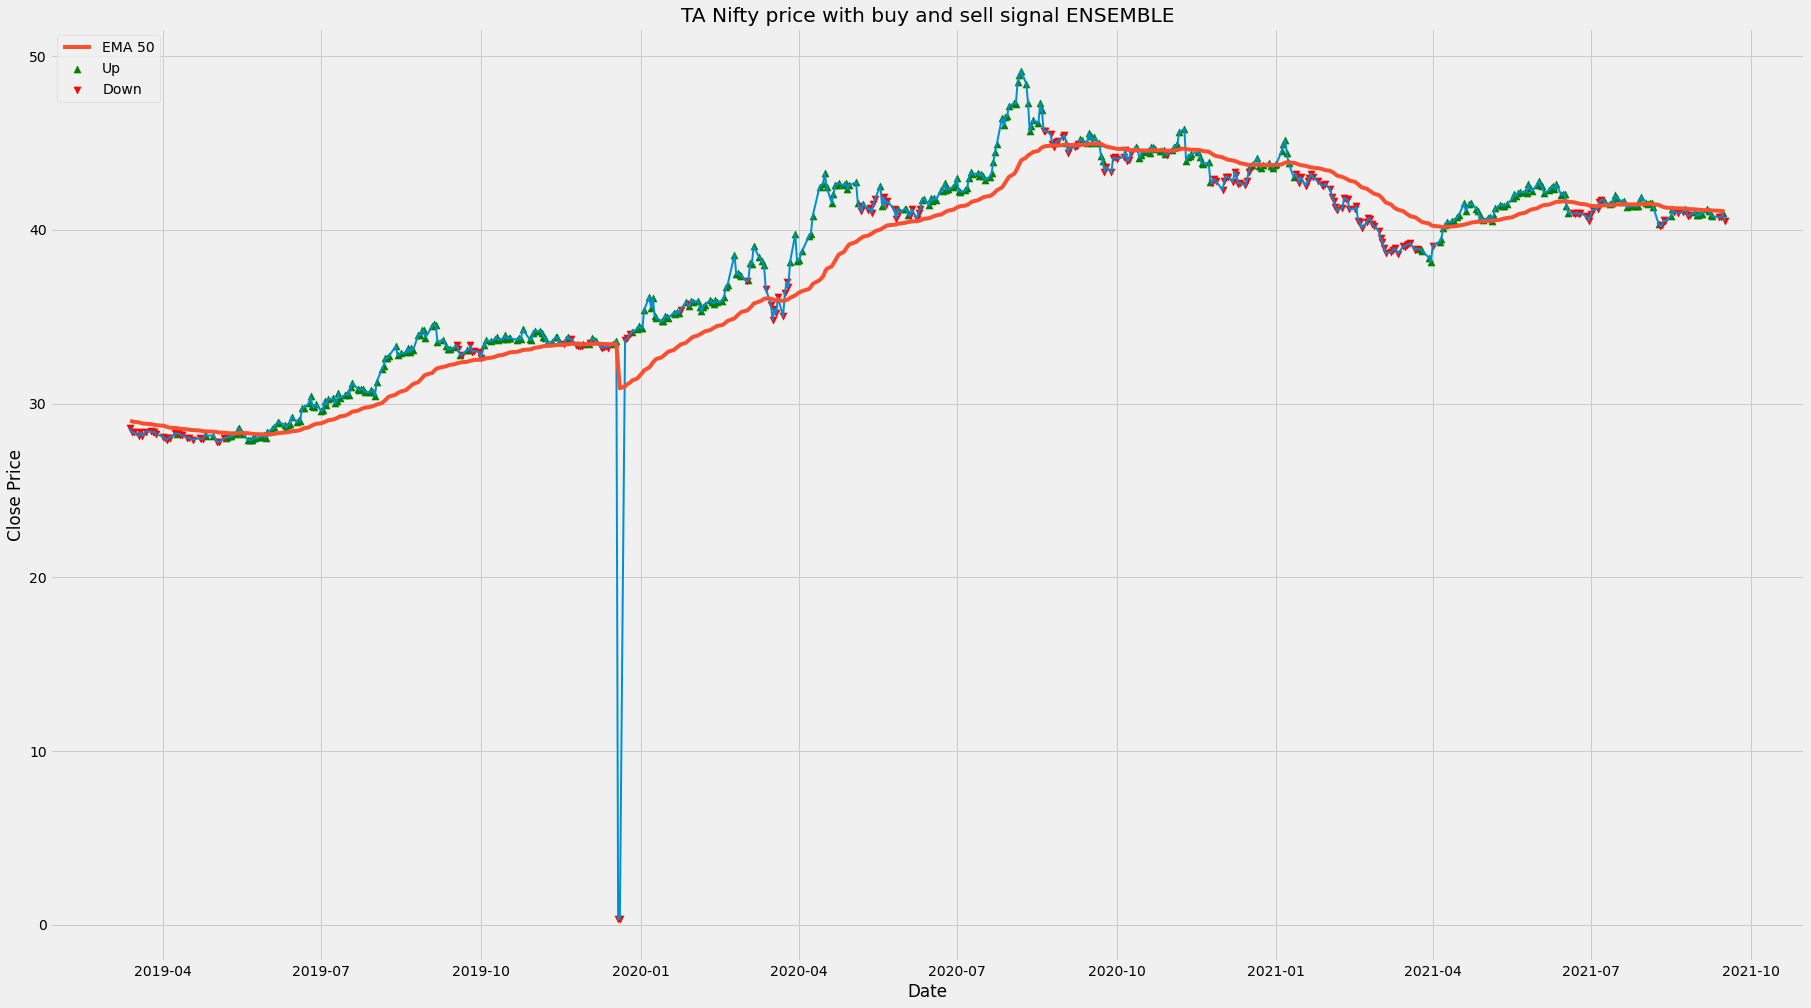

In [1038]:
plt.figure(figsize=(28,16))
## plotting the buy and sell signals on graph
plt.plot(df.index.values[-l:],df['Close'].values[-l:],'-',linewidth=2)
plt.scatter(pred.loc[pred['Buy_ensemble'] ==1 , 'Date'].values,pred.loc[pred['Buy_ensemble'] ==1, 'Close'].values, label='Up', color='green', s=50, marker="^")
plt.scatter(pred.loc[pred['Sell_ensemble'] ==0 , 'Date'].values,pred.loc[pred['Sell_ensemble'] ==0, 'Close'].values, label='Down', color='red', s=50, marker="v")
#plt.scatter(pred.loc[pred['Neutral'] ==0 , 'Date'].values,pred.loc[pred['Neutral'] ==0, 'Close'].values, label='skitscat', color='blue', s=50, marker="*")
plt.plot(df.index,df['EMA_50'].values[-l:],label='EMA 50')
#plt.plot(df.index,df['EMA_26'].values[-l:], label='EMA 26')

## Adding labels
plt.xlabel('Date')  
plt.ylabel('Close Price') 
plt.legend(loc='upper left') 
plt.title('TA Nifty price with buy and sell signal ENSEMBLE') 
plt.show();

/content/pandas-technical-indicators/confusionMatrix.py:22: RuntimeWarning: invalid value encountered in long_scalars
  percision = true_positives / (true_positives + false_positives)
/content/pandas-technical-indicators/confusionMatrix.py:23: RuntimeWarning: invalid value encountered in long_scalars
  recall = true_positives / (true_positives + false_negatives)


Accuracy: 100.0
Percision: nan
Recall: nan
Specificity: 100.0


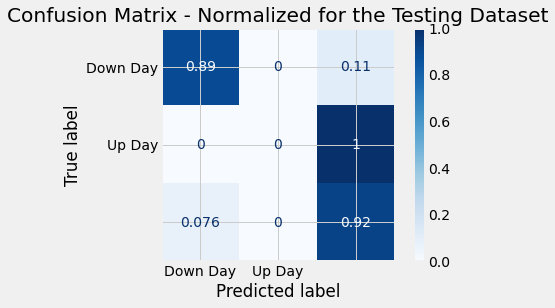

In [1039]:
cm.confus_matrix(df.Signal_Flag,preds,rand_frst_clf,new_data,actuals,plot=True )


Accuracy: 93.18734793187348
Percision: 93.72197309417041
Recall: 93.72197309417041
Specificity: 92.5531914893617


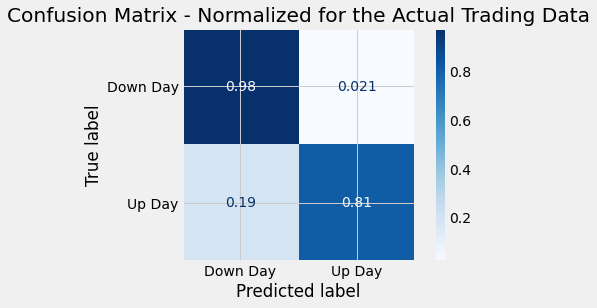

In [1040]:
cm.confus_matrix(y_test,y_pred,rand_frst_clf,X_test,y_test,plot=True, test=False)


In [1041]:
# saving the dataframe
pred[['Date','signalF']].to_csv('/content/rf_TA.csv')

In [1042]:
pred.head(1)

,Date,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
0,2019-03-13,-1.0,28.595501,0,0,-2.0,0,0,0,0


In [1043]:
pred.set_index('Date',inplace=True)

In [1044]:
pred.tail(2)

,predsrandom_forest,Close,Buy_ind,Sell_ind,ensemble,Buy_ensemble,Sell_ensemble,signal4theday,signalF
Date,,,,,,,,,
2021-09-15,-1.0,40.959999,0,0,0.0,1,1,1,1
2021-09-16,-1.0,40.520000,0,0,-1.0,0,0,0,0


In [1045]:
pred['actual']=np.where(pred.Close>pred.Close.shift(1),1,0)
pred['dummy']= np.where(pred.signal4theday==0,0,1)
pred['dummyS']=pred['dummy'].shift(1)
pred=pred.dropna()

In [1046]:
pred.signalF.value_counts()

1    416
0    201
Name: signalF, dtype: int64

In [1047]:
pred.dummyS.value_counts()

1.0    416
0.0    201
Name: dummyS, dtype: int64

In [1048]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(pred.actual, pred.dummyS)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(pred.actual, pred.dummyS)

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)
f1score= 2*recall*percision/(percision+recall)
print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print('F1-Score: {}'.format(float(f1score)))
print('Average Precision : {}'.format(float(average_precision)))

Accuracy: 0.5105348460291734
Percision: 0.5336538461538461
Recall: 0.6727272727272727
Specificity: 0.3240418118466899
F1-Score: 0.5951742627345844
Average Precision : 0.5340440151420702


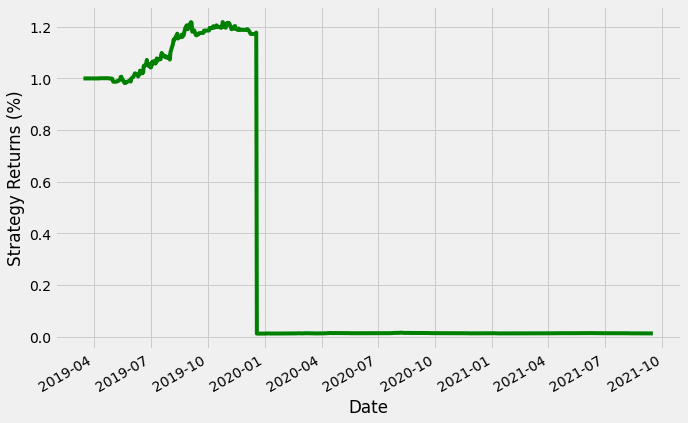

In [1049]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_Return'] = pred.Return * pred.dummy.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_Return+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()

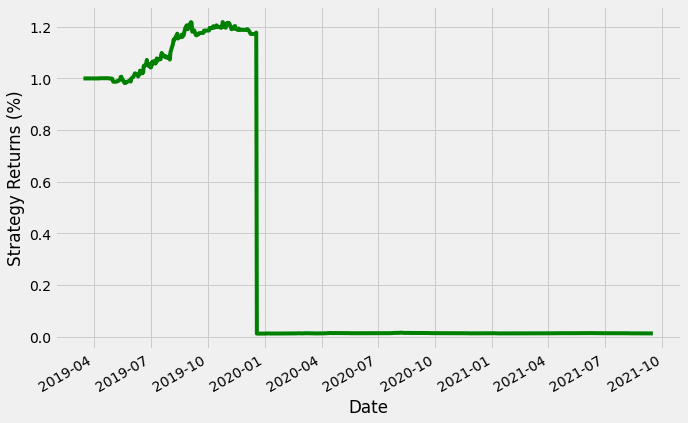

In [1050]:
# Calculate daily returns
pred['Return'] = pred.Close.pct_change()

# Calculate strategy returns
pred['Strategy_F'] = pred.Return * pred.signalF.shift(1)

# Calculate geometric returns
geometric_returns = (pred.Strategy_F+1).cumprod()

# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()